In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
x_train = train.drop('label',axis=1)
y_train = train['label']

In [6]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [7]:
x_train = x_train / 255 
test = test / 255

In [14]:
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [19]:
y_train = to_categorical(y_train,num_classes=10)

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state = 42)

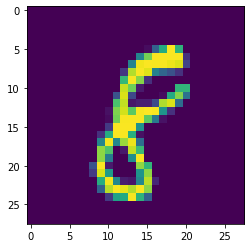

In [23]:
plt.imshow(x_train[0])

In [26]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

In [27]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08,decay=0)

In [28]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'] )

In [29]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001)

In [30]:
epochs = 1
batch_size = 86

In [31]:
generator = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

generator.fit(x_train)

In [32]:
history = model.fit_generator(generator.flow(x_train,y_train,batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_val,y_val),
    verbose=2,
    steps_per_epoch=x_train.shape[0],
    callbacks=[lr_reduction],
    )

C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37800/37800 - 130s - loss: 0.4106 - accuracy: 0.8677 - val_loss: 0.0524 - val_accuracy: 0.9855


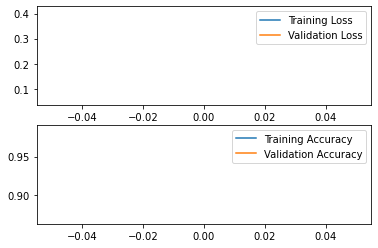

In [35]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'],label='Training Loss')
ax[0].plot(history.history['val_loss'],label='Validation Loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'],label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
ax[1].legend(loc='best')

In [37]:
model.predict_classes(test)

C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [41]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1] = model.predict_classes(test)

C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
submission.to_csv('submission.csv',index=False)